In [ ]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import StandardScaler #normal datas
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
!pip install torchmetrics==0.8.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 17n3UV16quhH4PLMAn_SlIDyYGcTsQhiG

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17n3UV16quhH4PLMAn_SlIDyYGcTsQhiG
To: /content/diabetes.csv
100% 24.8k/24.8k [00:00<00:00, 32.7MB/s]


In [ ]:
diabet_data = pd.read_csv('/content/diabetes.csv')
diabet_data.head(12)

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Age,Class
0,6,148,72,35,0,33.6,50,positive
1,1,85,66,29,0,26.6,31,negative
2,8,183,64,0,0,23.3,32,positive
3,1,89,66,23,94,28.1,21,negative
4,0,137,40,35,168,43.1,33,positive
5,5,116,74,0,0,25.6,30,negative
6,3,78,50,32,88,31.0,26,positive
7,10,115,0,0,0,35.3,29,negative
8,2,197,70,45,543,30.5,53,positive
9,8,125,96,0,0,0.0,54,positive


In [ ]:
datas = diabet_data.iloc[:,:-1]
labels = diabet_data.iloc[:,-1]

In [ ]:
datas_train , datas_test , labels_train , labels_test = train_test_split(datas , labels , test_size = 0.2 , random_state = None , shuffle = False)


In [ ]:
scaler = StandardScaler()
scaler.fit(datas_train)
datas_train_scale = scaler.transform(datas_train)
datas_test_scale = scaler.transform(datas_test)

In [ ]:
def convert_str(str_input):
  label = []
  for i in str_input:
    if i == 'negative':
      label.append(1)
    else:
      label.append(0)
  return label

In [ ]:
lables_train_int = convert_str(labels_train)
labels_test_int = convert_str(labels_test)

# dataset and **model**

In [ ]:
class mydataset(Dataset):
  def __init__(self , datas , labels):
    super(mydataset,self).__init__()
    self.datas = torch.tensor(datas , dtype=torch.float)
    self.labels = torch.tensor(labels , dtype=torch.float).unsqueeze(1)
  def __getitem__(self, index):
    return self.datas[index] , self.labels[index]
  def __len__(self):
    return self.datas.shape[0]

In [ ]:
trainset = mydataset(datas_train_scale , lables_train_int)
trainloader = DataLoader(trainset , shuffle = True , batch_size = 32 )

testset = mydataset(datas_test_scale , labels_test_int)
testloader = DataLoader(testset , shuffle = False , batch_size = 32 )

In [ ]:
class fnn(nn.Module):
  def __init__(self,input,dropout):
    super(fnn,self).__init__()
    self.mlp = nn.Sequential(nn.Linear(in_features=input , out_features=50),
                             nn.ReLU(),
                             nn.Dropout(dropout),
                             nn.Linear(50,300))
                              #3x10x10
    self.conv = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=6,kernel_size=3,padding='same'),#6x8x8
                              nn.BatchNorm2d(6),
                              nn.ReLU(),
                              nn.Conv2d(in_channels=6,out_channels=8,kernel_size=3,padding='same'),#8x6x6
                              nn.ReLU(),
                              nn.Conv2d(in_channels=8,out_channels=3,kernel_size=4),#6x8x8
                              nn.BatchNorm2d(3),
                              nn.ReLU())
    
    self.mlp2 = nn.Sequential(nn.ReLU(),
                             nn.Linear(147,80),
                             nn.ReLU(),
                             nn.Linear(80,20),
                             nn.Dropout(dropout),
                             nn.ReLU(),
                             nn.Linear(20,1),
                             nn.Sigmoid())
    self.flatt = nn.Flatten()
  def forward(self,x):
    mlp = self.mlp(x)
    reshape = torch.reshape(mlp , (-1,3,10,10))
    conv = self.conv(reshape)
    flattening = self.flatt(conv)
    out = self.mlp2(flattening)

    return out

In [ ]:
model = fnn(input=7,dropout=0.4).to(device)
# model

# some setting

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr = 0.02,weight_decay=0.005,momentum=0.9)
criterion = nn.BCELoss()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import logging
logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('Diabet  fnn:  ')

In [ ]:
import sys
import torchmetrics
import logging
from tqdm import tqdm
# logger = logging.getLogger('CIFAR100')
# # writer = SummaryWriter('runs/cifar100_resnet18')
# writer = SummaryWriter('runs/test1')  #related to tensor board

# trian and test

In [ ]:
train_accuracy=[]
train_loss=[]
out = []
target = []
def train_network(model, train_loader, train_dataset):
  epoch_accuracy = []
  total_loss = AverageMeter()
  model.train()
  num_corrects =0.0
  for (x, labels) in tqdm(train_loader): #for each batch calculate something for 1 epoch.
    x, labels = x.to(device) , labels.to(device)
    outputs = model(x)
    loss = criterion(outputs, labels) #loss between out and lables
    optimizer.zero_grad() #befor use next line better to use zero.grad( )
    loss.backward()
    optimizer.step()
    total_loss.update(loss)
    num_corrects += ((outputs>=0.5).float() == labels).float().sum()
    if epoch==99:
      out.append(outputs)
      target.append(labels)
  avg_acc = num_corrects / len(train_dataset)
  epoch_accuracy.append(avg_acc)
  train_accuracy.append(avg_acc.cpu())
  train_loss.append(total_loss.avg.cpu().detach().numpy() )
  logger.info(f'Train: Epoch:{epoch} \t Loss:{total_loss.avg:.4} \t Accuracy:{avg_acc:.4}')
  # conmat = confusion_matrix(labels, outputs)
  return 

In [ ]:
test_accuracy=[]
test_loss=[]
def test(model, test_laoder, test_dataset):
  model.eval()
  total_loss = AverageMeter()
  num_corrects =0.0
  for (x, labels) in tqdm(test_laoder):
    x, labels = x.to(device) , labels.to(device)
    outputs = model(x)
    loss = criterion(outputs, labels)
    total_loss.update(loss)
    num_corrects += ((outputs>=0.5).float() == labels).float().sum()
  avg_accuracy = num_corrects / len(test_dataset)
  test_accuracy.append(avg_accuracy.cpu())
  test_loss.append(total_loss.avg.cpu().detach().numpy() )
  logger.info(f'Test: Epoch:{epoch} \t Loss:{total_loss.avg:.4} \t Accuracy:{avg_accuracy:.4}')
  return avg_accuracy,total_loss

# Running and plot

In [ ]:
start , end = 0,100
for epoch in range(start , end):
  train_network(model, trainloader, trainset)
  test(model, testloader, testset)
  print()

# Plot results

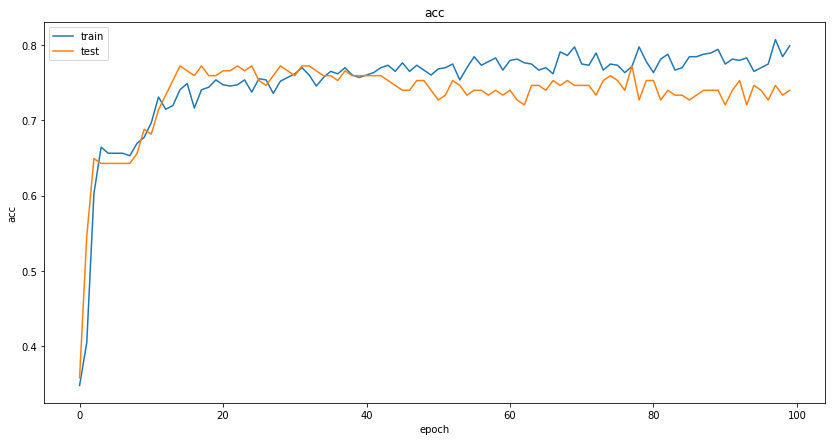

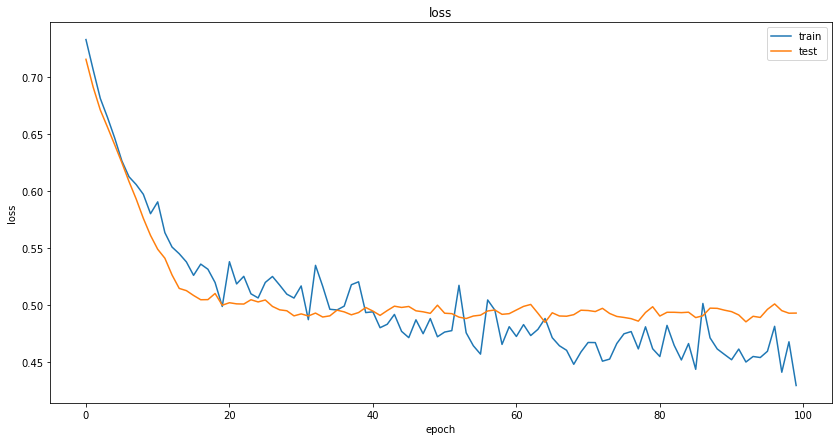

In [ ]:
plt.figure(figsize=(14,7))
plt.title("acc")
plt.plot(train_accuracy,label="train")
plt.plot(test_accuracy,label="test")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

print('\n')

plt.figure(figsize=(14,7))
plt.title("loss")
plt.plot(train_loss,label="train")
plt.plot(test_loss,label="test")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()



# Confusion matrix

In [ ]:
pred = []
true = []

for j in range(20):
  for i in range(len(out[j])):
    if out[j][i]>0.8:
      pred.append(1.0)
    else:
      pred.append(0.0)

for k in range(20):
  for l in range(len(target[k])):
    if target[k][l]==1:
      true.append(1)
    else:
      true.append(0)

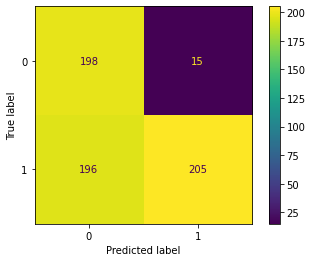

In [ ]:
cm = confusion_matrix(true,pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm )
disp.plot()

# eval

In [ ]:
def eval(inputs):
  model.eval()
  # inputs = torch.tensor(inputs).unsqueeze(0)
  inputs = pd.core.frame.DataFrame(inputs)
  scaler = StandardScaler()
  scaler.fit(inputs)
  inputs = scaler.transform(inputs)
  inputs =inputs.T
  data = torch.tensor(inputs,dtype=torch.float).to(device)
  out = model(data)
  if out.item()< 0.3:
    print(' The result for  person with this information is **Positive** \n')
  else:
    print('The result for  person with this information is **Negative** \n')

In [ ]:
new = torch.tensor([2	,89	,66,	23,	94	,28.1,	21])
eval(new)

The result for  person with this information is **Negative** 

